In [1]:
import os
os.chdir('../../..')

In [2]:
import convokit

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
from convokit import Corpus, HyperConvo, TensorDecomposer

First we download the reddit corpus:

In [5]:
# corpus = Corpus(filename="convokit/thread_generator/fake-corpus-trajectory-40")
corpus = Corpus(filename="convokit/thread_generator/annotated-fake-trajectory-experiment")
# corpus = Corpus(filename="convokit/tensor_decomposer/experiments/reddit-trajectory-subset-annotated")

In [6]:
corpus.print_summary_stats()

Number of Speakers: 40
Number of Utterances: 375000
Number of Conversations: 15000


In [43]:
hyperconv_range = range(2, 20+1)

In [8]:
# def multi_hyperconv_transform(corpus, hyperconv_range):
#     hc_transformers = [HyperConvo(prefix_len=i, feat_name="hyperconvo-{}".format(i), invalid_val=-1) for i in hyperconv_range]
#     for idx, hc in enumerate(list(reversed(hc_transformers))):
#         print(hyperconv_range[-1]-idx)
#         hc.transform(corpus)
# multi_hyperconv_transform(corpus, hyperconv_range)
# corpus.dump('annotated-fake-trajectory-40', base_path="convokit/thread_generator")

In [44]:
# grown = 0
# thresh = 1.5
# for convo in corpus.iter_conversations():
#     utts40 = convo.get_chronological_utterance_list()
#     utts20 = utts40[:20]
#     num_spkrs_20 = len(set(utt.speaker.id for utt in utts20))
#     num_spkrs_40 = len(set(utt.speaker.id for utt in utts40))
#     convo.meta['grown'] = (num_spkrs_40 / num_spkrs_20) >= thresh
#     grown += (num_spkrs_40 / num_spkrs_20) >= thresh

In [7]:
grown = 0
thresh = 1.5
for convo in corpus.iter_conversations():
    try:
        recip_div = convo.meta['hyperconvo-25']['count[reciprocity motif]'] / convo.meta['hyperconvo-20']['count[reciprocity motif]']
    except ZeroDivisionError:
        if convo.meta['hyperconvo-20']['count[reciprocity motif]'] == 0:
            recip_div = 0
        else:
            recip_div = 10
    convo.meta['grown'] = recip_div >= thresh
    grown += convo.meta['grown']

In [72]:
grown2 = 0
thresh = 3.0
for convo in corpus.iter_conversations():
    recip_diff = convo.meta['hyperconvo-25']['count[reciprocity motif]'] - convo.meta['hyperconvo-20']['count[reciprocity motif]']
    convo.meta['grown2'] = recip_diff >= thresh
    grown2 += convo.meta['grown2']

In [8]:
grown

6052

In [98]:
grown2

5049

In [14]:
from convokit import Classifier
from sklearn.model_selection import KFold

In [10]:
# clf = Classifier(obj_type="conversation", pred_feats=['hyperconvo-20'], labeller=lambda convo: convo.meta['grown'],
#                 clf_feat_name='hyperconv-pred', clf_prob_feat_name='hyperconv-pred-score'
#                 )

In [73]:
clf = Classifier(obj_type="conversation", pred_feats=['hyperconvo-20'], labeller=lambda convo: convo.meta['grown2'],
                clf_feat_name='hyperconv-pred', clf_prob_feat_name='hyperconv-pred-score'
                )

In [16]:
res = clf.evaluate_with_cv(corpus, cv=KFold(n_splits=5, shuffle=True))

Using corpus objects...
Running a cross-validated evaluation...
Done.


In [17]:
np.mean(res)

0.8396000000000001

In [74]:
clf.fit(corpus)

In [76]:
clf_feats = list(corpus.random_conversation().meta['avg'])
clf.get_coefs(clf_feats, lambda model: model.coef_.toarray()[0])

,coef
feat_name,
is-present[outgoing triads over mid-thread],0.380000
is-present[dyadic interaction motif over mid-thread],0.333276
is-present[reciprocity motif over mid-thread],0.313276
max[outdegree over C->C responses],0.241767
max[outdegree over C->c responses],0.240562
2nd-largest[outdegree over C->c responses],0.212952
2nd-largest[outdegree over C->C responses],0.210860
argmax[outdegree over C->c mid-thread responses],0.178536
is-present[reciprocity motif],0.173276


## Tensor feats (rank 3)

In [18]:
td = TensorDecomposer(obj_type="conversation",
                      feature_set=["hyperconvo-{}".format(i) for i in range(2, 21)],
                      group_func=lambda convo: convo.get_utterance(convo.id).meta['subreddit'],
                      rank=3, tensor_func='tensorly'
                     )

In [19]:
td.fit(corpus)

Constructing tensor...Done.
Decomposing tensor...Done.


In [20]:
td.transform(corpus)

In [21]:
from convokit import BoWClassifier

In [22]:
clf_tensor = BoWClassifier(obj_type="conversation", vector_name='tensor_factor', 
                           labeller=lambda convo: convo.meta['grown'],
                clf_feat_name='tensor-pred', clf_prob_feat_name='tensor-pred-score'
                )

Initializing default classification model (standard scaled logistic regression)


In [23]:
res = clf_tensor.evaluate_with_cv(corpus, cv=KFold(n_splits=5, shuffle=True))

Using corpus objects...

Running a cross-validated evaluation...
Done.


In [24]:
np.mean(res)

0.8128

In [25]:
for convo in corpus.iter_conversations():
    convo.meta['tensor_rank3'] = convo.meta['tensor_factor']

### Rank 9 decomp

In [7]:
td_9 = TensorDecomposer(obj_type="conversation",
                      feature_set=["hyperconvo-{}".format(i) for i in range(2, 21)],
                      group_func=lambda convo: convo.get_utterance(convo.id).meta['subreddit'],
                      rank=9, tensor_func='tensorly'
                     )

In [8]:
td_9.fit(corpus)

Constructing tensor...Done.
Decomposing tensor...Done.


In [9]:
td_9.transform(corpus)

In [86]:
td_9.tensor.shape

(19, 15000, 140)

Report generated at convokit/tensor_decomposer/reports/8_Jun_normal/report.html


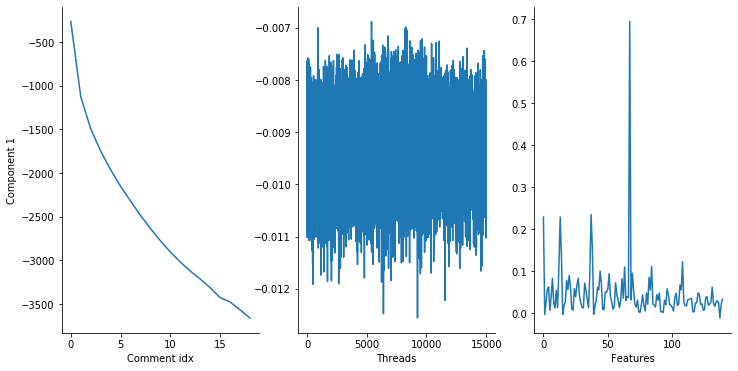

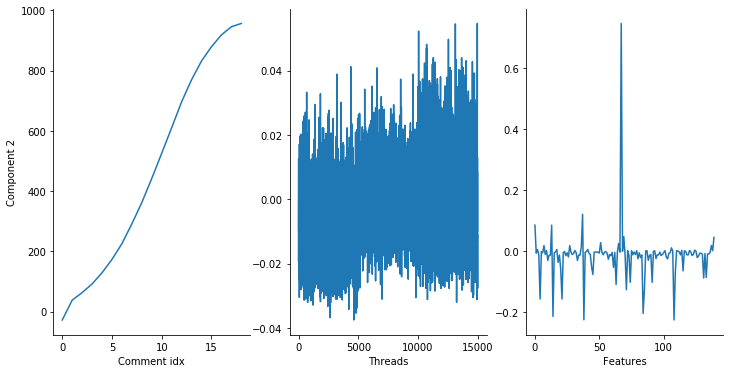

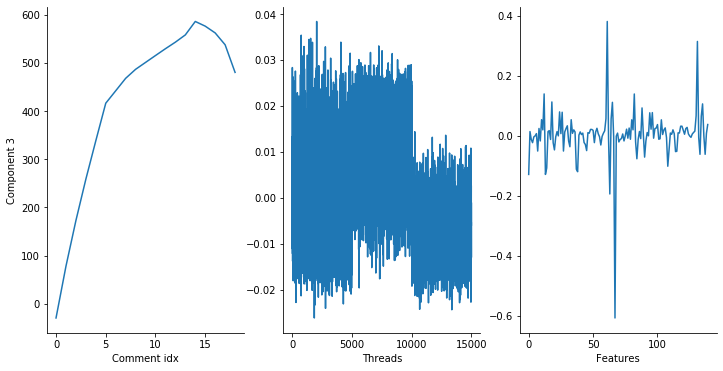

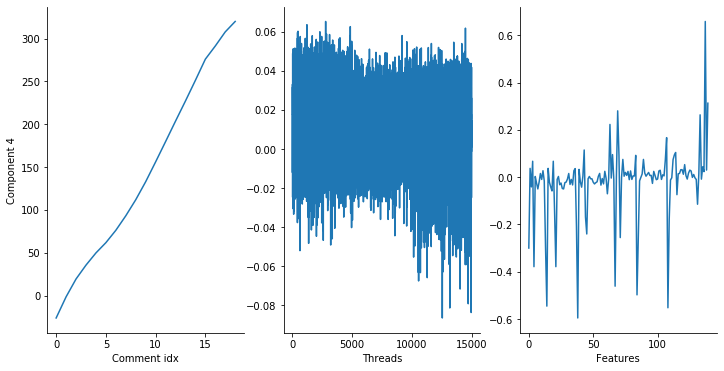

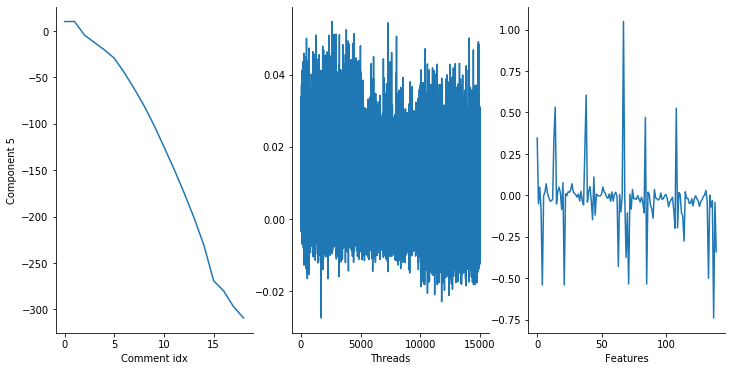

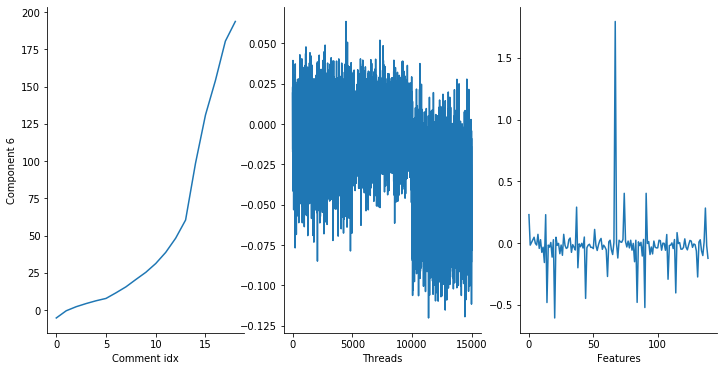

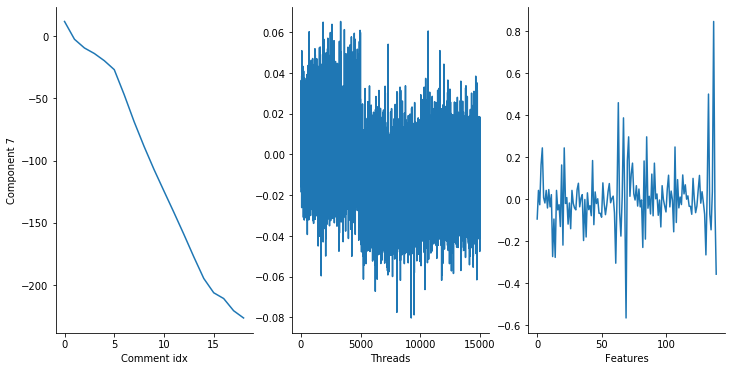

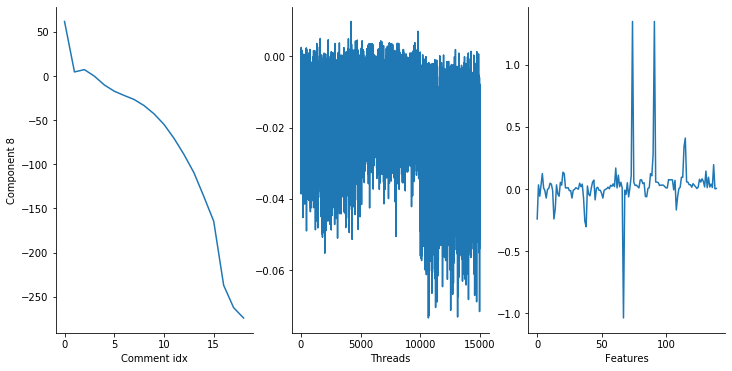

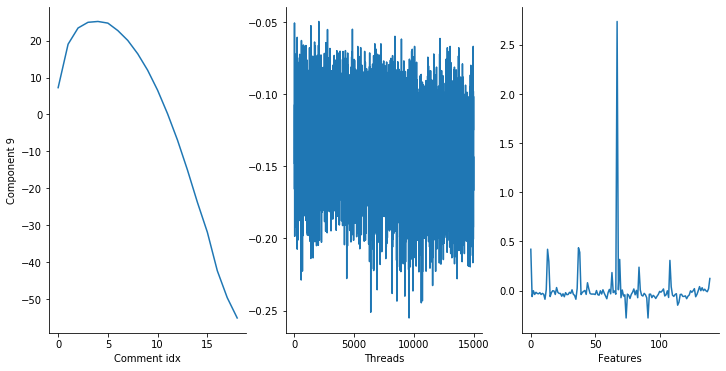

In [10]:
td_9.summarize(corpus, axis_names=['Comment idx', 'Threads', 'Features'],
              output_dir="convokit/tensor_decomposer/reports/8_Jun_normal", report_title="8 Jun Normal")

In [29]:
clf_tensor_9 = BoWClassifier(obj_type="conversation", vector_name='tensor_factor', 
                             labeller=lambda convo: convo.meta['grown'],
                clf_feat_name='tensor-pred', clf_prob_feat_name='tensor-pred-score'
                )

Initializing default classification model (standard scaled logistic regression)


In [30]:
res = clf_tensor_9.evaluate_with_cv(corpus, cv=KFold(n_splits=5, shuffle=True))
print(res)

Using corpus objects...

Running a cross-validated evaluation...
Done.
[0.84766667 0.85333333 0.84       0.82933333 0.841     ]


In [31]:
np.mean(res)

0.8422666666666666

### Baseline: class information

In [32]:
# for generated data
for idx, convo in enumerate(corpus.iter_conversations()):
    convo.meta['class1'] = int((idx / 5000) < 1)
    convo.meta['class2'] = int(1 <= (idx / 5000) < 2)
    convo.meta['class3'] = int(idx/5000 >= 2)

In [33]:
clf_base = Classifier(obj_type="conversation", pred_feats=['class1', 'class2', 'class3'], 
                 labeller=lambda convo: convo.meta['grown'],
                clf_feat_name='base-pred', clf_prob_feat_name='base-pred-score'
                )

In [34]:
np.mean(clf_base.evaluate_with_cv(corpus, cv=KFold(n_splits=5, shuffle=True)))

Using corpus objects...
Running a cross-validated evaluation...
Done.


0.8888

## Benchmarks

In [35]:
for convo in corpus.iter_conversations():
    convo.meta['concat'] = dict()
    for idx in range(2, 20+1):
        d = convo.meta['hyperconvo-{}'.format(idx)].copy()
        convo.meta['concat'].update({k+"_"+str(idx): v for k, v in d.items()})

In [36]:
len(corpus.random_conversation().meta['concat'])

2660

In [37]:
concat_data = dict()
for convo in corpus.iter_conversations():
    concat_data[convo.id] = convo.meta['concat']
concat_df = pd.DataFrame(concat_data).T

In [38]:
np.sum(np.sum(pd.isnull(concat_df))) # NaN values

0

In [39]:
from sklearn.preprocessing import StandardScaler

In [40]:
concat_vals = concat_df.values.astype('float64')
concat_vals_std = StandardScaler().fit_transform(concat_vals)

### Benchmark: PCA-3[Hyperconvo-2 to Hyperconvo-20]

In [41]:
from sklearn.model_selection import KFold

In [42]:
y = []
for convo in corpus.iter_conversations():
    y.append(int(convo.meta['grown']))

In [43]:
from sklearn.decomposition import PCA

In [44]:
X = concat_vals_std

In [45]:
y = np.array(y)

In [46]:
from sklearn import svm

In [47]:
pca_3 = PCA(n_components=3)
kf = KFold(n_splits=5, shuffle=True)
acc = []
for train_index, test_index in kf.split(X):
    print(train_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train_pca = pca_3.fit_transform(X_train)
    X_test_pca = pca_3.transform(X_test)
    clf = svm.SVC(C=0.02, kernel='linear', probability=True)
    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_test_pca)
    acc.append(np.mean(y_pred == y_test))

[    0     1     2 ... 14996 14997 14999]
[    0     1     2 ... 14997 14998 14999]
[    3     4     5 ... 14996 14997 14998]
[    0     1     2 ... 14996 14998 14999]
[    0     1     2 ... 14997 14998 14999]


In [48]:
print(np.mean(acc))

0.8194000000000001


### Benchmark: PCA-9[Hyperconvo-2 to Hyperconvo-20]

In [49]:
pca_9 = PCA(n_components=9)
kf = KFold(n_splits=5, shuffle=True)
acc_9 = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train_pca = pca_9.fit_transform(X_train)
    X_test_pca = pca_9.transform(X_test)
    clf = svm.SVC(C=0.02, kernel='linear', probability=True)
    clf.fit(X_train_pca, y_train)
    y_pred = clf.predict(X_test_pca)
    acc_9.append(np.mean(y_pred == y_test))

In [50]:
print(np.mean(acc_9))

0.8327333333333333


### Benchmark: average[Hyperconvo-2 to Hyperconvo-20]

In [51]:
from collections import defaultdict

convo_to_avg = dict()
for convo in corpus.iter_conversations():
    avg_dict = defaultdict(int)
    for idx in range(2, 20+1):
        d = convo.meta['hyperconvo-{}'.format(idx)]
        for k, v in d.items():
            avg_dict[k] += v
    convo_to_avg[convo.id] = avg_dict

In [52]:
for convo_id, avg_dict in convo_to_avg.items():
    corpus.get_conversation(convo_id).meta['avg'] = dict(avg_dict)

In [77]:
df_avg = pd.DataFrame(convo_to_avg).T

In [79]:
df_avg['group'] = [1]*5000 + [2]*5000 + [3]*5000

In [84]:
df_avg.groupby('group').mean()['mean[outdegree over C->c responses]']

group
1    26.774362
2    29.068090
3    20.791631
Name: mean[outdegree over C->c responses], dtype: float64

In [53]:
clf_avg = Classifier(obj_type="conversation", pred_feats=['avg'], 
                 labeller=lambda convo: convo.meta['grown']
                )

In [54]:
res = clf_avg.evaluate_with_cv(corpus, cv=KFold(n_splits=5, shuffle=True))

Using corpus objects...
Running a cross-validated evaluation...
Done.


In [55]:
print(res)
print(np.mean(res))

[0.83633333 0.84366667 0.84066667 0.84433333 0.84433333]
0.8418666666666667


In [57]:
clf_avg.fit(corpus)

In [68]:
clf_feats = list(corpus.random_conversation().meta['avg'])
clf_avg.get_coefs(clf_feats, lambda model: model.coef_.toarray()[0])

,coef
feat_name,
mean[outdegree over C->c responses],0.437180
2nd-largest / max[indegree over C->C mid-thread responses],0.141749
entropy[outdegree over C->c responses],0.141403
prop-nonzero[outdegree over C->c mid-thread responses],0.124642
prop-nonzero[outdegree over C->C mid-thread responses],0.124642
norm.2nd-largest[outdegree over C->C mid-thread responses],0.121072
entropy[indegree over C->C mid-thread responses],0.117557
2nd-largest / max[indegree over C->C responses],0.115675
prop-nonzero[indegree over C->c mid-thread responses],0.107979


## Combined feature sets

In [92]:
grown

6233

In [91]:
corpus.print_summary_stats()

Number of Speakers: 40
Number of Utterances: 375000
Number of Conversations: 15000


### Hyperconvo-20 + TCA (rank 9)

In [93]:
for convo in corpus.iter_conversations():
    convo.meta['tensor_dict'] = {idx: v for idx, v in enumerate(convo.meta['tensor_factor'])}

In [94]:
clf_all = Classifier(obj_type="conversation", pred_feats=['hyperconvo-20', 'tensor_dict'], labeller=lambda convo: convo.meta['grown'],
                )

In [95]:
res = clf_all.evaluate_with_cv(corpus)

Using corpus objects...
Running a cross-validated evaluation...
Done.


In [96]:
np.mean(res)

0.8207333333333333

### Hyperconvo-20 + TCA (rank 3)

In [81]:
for convo in corpus.iter_conversations():
    convo.meta['tensor_dict3'] = {idx: v for idx, v in enumerate(convo.meta['tensor_rank3'])}

In [82]:
clf_all_3 = Classifier(obj_type="conversation", pred_feats=['hyperconvo-15', 'tensor_dict3'], labeller=lambda convo: convo.meta['grown'],
                )

In [83]:
res = clf_all_3.evaluate_with_cv(corpus)
np.mean(res)

Using corpus objects...
Running a cross-validated evaluation...
Done.


0.7333333333333334